# <u>Hands-on work</u>: Churn Prediction

### Business problem

![](img/1_X-oZNRw5Pnef-kR9CgLx1g.png)

Churn or retention Rate is an indication of how good is your product market fit (PMF). If your PMF is not satisfactory, you should see your customers churning very soon. One of the powerful tools to improve Retention Rate (hence the PMF) is Churn Prediction. By using this technique, you can easily find out who is likely to churn in the given period. In this notebook, we will use a dataset having these different columns:

- `RowNumber`: number of rows entered
- `CustomerId`: identifier of each customer
- `Surname`: surname of each customer
- `CreditScore`: number that reflects the likelihood of you paying credit back
- `Geography`: name of coutries of each customer
- `Gender`: gender of each customer
- `Age`: age of each customer
- `Tenure`: number of mortgages on each customer home for a certain pre-determined amount
- `Balance`: an amount of money each customer have in a bank account
- `NumOfProducts`: number of products of each customer
- `HasCrCard`: if a customer has a card or not
- `IsActiveMember`: if a customer is a active member
- `EstimatedSalary`: salary of each customer
- `Exited`: target column

And go over the following steps to develop a Churn Prediction model:

##### I- Exploratory data analysis
##### II- Feature engineering
##### III- Features select
##### IV- Feature select/tuning

In [2]:
### Before to start, we gonna redefine our dataset in 2 set.
### we will have the Train and holdout data.

import pandas as pd
import numpy as np

df= pd.read_csv("Churn.csv")
lenght= int(len(df)*0.8)
train= df[:lenght]
holdout= df[lenght:].reset_index().drop("index",axis=1)

In [3]:
print(holdout.shape[0])
holdout.head()

2000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,8001,15629002,Hamilton,747,Germany,Male,36,8,102603.30,2,1,1,180693.61,0
1,8002,15798053,Nnachetam,707,Spain,Male,32,9,0.00,2,1,0,126475.79,0
2,8003,15753895,Blue,590,Spain,Male,37,1,0.00,2,0,0,133535.99,0
3,8004,15595426,Madukwe,603,Spain,Male,57,6,105000.85,2,1,1,87412.24,1
4,8005,15645815,Mills,615,France,Male,45,5,0.00,2,1,1,164886.64,0


In [4]:
print(train.shape[0])
train.head()

8000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### I- <u>Exploratory data analysis</u>

**Columns to delete:**
we goona delete columns that we don't need to make our predictions. These columns have some trouble like data leak or just not enough useful for our working.

In [5]:
columns_to_delete= ["RowNumber","CustomerId","Surname","HasCrCard","IsActiveMember"]
train_copy= train.copy()
holdout_copy= holdout.copy()
train_copy.drop(columns_to_delete, axis=1, inplace=True)
holdout_copy.drop(columns_to_delete, axis=1, inplace=True)

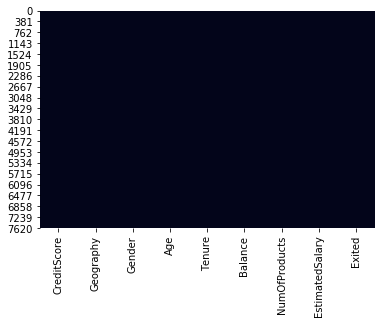

In [6]:
### Let's look at columns with null values

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train_null= train_copy.isnull()
sns.heatmap(train_null,cbar= False)
plt.show()

In [7]:
print(train_null.sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
EstimatedSalary    0
Exited             0
dtype: int64


### II- <u>Feature engineering</u>

**Functions Pipeline:**
   Let's build the functions who allow us to transform our features.

In [8]:
### Let's look at how to transform CreditScore column

train_copy["CreditScore"].describe(include="all")

count    8000.000000
mean      650.179625
std        96.844314
min       350.000000
25%       583.000000
50%       651.000000
75%       717.000000
max       850.000000
Name: CreditScore, dtype: float64

In [9]:
### Let's assume that we have 3 credit-score type: weak, middle and high.

def w_m_h(val):
    if val < 600:
        return 1
    elif val >= 600 and val < 710:
        return 2
    return 3

def process_CreditScore(df):
    df["CreditScore"]= df["CreditScore"].map(w_m_h)
    return df

In [10]:
### Let's look at Geography column

train_copy["Geography"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
def process_Geography(df):
    dummies = pd.get_dummies(df["Geography"],prefix="Geography")
    df = pd.concat([df,dummies],axis=1)
    df= df.drop("Geography",axis=1)
    return df

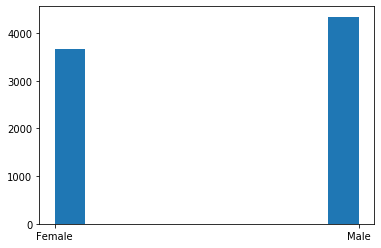

In [12]:
### Let's look at Gender column
### visualize this column

plt.hist(train_copy["Gender"])
plt.show()

In [13]:
def process_Gender(df):
    dummies = pd.get_dummies(df["Gender"],prefix="Gender")
    df = pd.concat([df,dummies],axis=1)
    df= df.drop("Gender",axis=1)
    return df

In [14]:
### Let's look at age column

train_copy["Age"].describe(include="all")

count    8000.000000
mean       38.937875
std        10.511224
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64

In [15]:
### Let's make a bin and one-hot encoding

def process_Age(df):
    cut_points = [18,35,60,100]
    label_names = ["Young Adult","Adult","Senior"]
    df["Age"] = pd.cut(df["Age"],cut_points,labels=label_names)
    dummies = pd.get_dummies(df["Age"],prefix="Age")
    df = pd.concat([df,dummies],axis=1)
    df= df.drop("Age",axis=1)
    return df

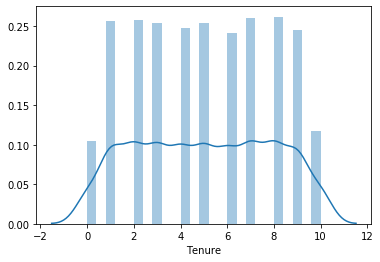

In [16]:
### Let's look at Tenure column

sns.distplot(train_copy["Tenure"])
plt.show()

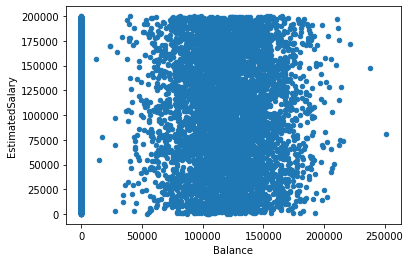

In [17]:
### Let's try to understand better, Balance and EstimedSalary columns
### look at the relation 

train_copy.plot.scatter(x="Balance",y="EstimatedSalary")
plt.show()

In [18]:
correlation= train_copy[["Balance","EstimatedSalary"]].corr()
print(correlation)

                  Balance  EstimatedSalary
Balance          1.000000         0.024345
EstimatedSalary  0.024345         1.000000


In [19]:
train_copy[["Balance","EstimatedSalary"]].describe(include="all")

,Balance,EstimatedSalary
count,8000.000000,8000.000000
mean,76800.037192,100198.588701
std,62391.192584,57524.002768
min,0.000000,11.580000
25%,0.000000,51271.410000
50%,97658.060000,100272.165000
75%,127827.332500,149372.387500
max,250898.090000,199992.480000


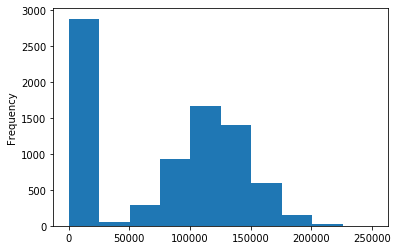

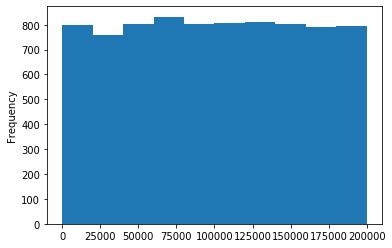

In [20]:
for c in ["Balance","EstimatedSalary"]:
    train_copy[c].plot.hist()
    plt.show()

In [21]:
### Let's make sum between these columns and normalize them.

def process_B_E(df):
    df["BE"]= df[["Balance","EstimatedSalary"]].sum(axis=1)
    df["BE"]= (df["BE"]-np.min(df["BE"]))/(np.max(df["BE"])-np.min(df["BE"]))
    df= df.drop(["Balance","EstimatedSalary"],axis=1)
    return df

In [22]:
### Let's look at how to transform NumOfProducts column

train_copy["NumOfProducts"].unique()

array([1, 3, 2, 4], dtype=int64)

In [23]:
def process_NumOfProducts(df):
    dummies = pd.get_dummies(df["NumOfProducts"],prefix="NumOfProducts")
    df = pd.concat([df,dummies],axis=1)
    df= df.drop("NumOfProducts",axis=1)
    return df

In [24]:
### Now let's assemble our functions

def process_engineering(df):
    """Create a dataframe who getting all features engineering process
    
        Usage
        ------     
        
        return: df= process_engineering(df)
    """
    
    df= process_CreditScore(df)
    df= process_Geography(df)
    df= process_Gender(df)
    df= process_Age(df)
    df= process_B_E(df)
    df= process_NumOfProducts(df)
    return df

train_copy= process_engineering(train_copy)
holdout_copy= process_engineering(holdout_copy)

In [25]:
print(train_copy.shape)
train_copy.head()

(8000, 16)


,CreditScore,Tenure,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age_Young Adult,Age_Adult,Age_Senior,BE,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,2,2,1,1,0,0,1,0,0,1,0,0.248391,1,0,0,0
1,2,1,0,0,0,1,1,0,0,1,0,0.481446,1,0,0,0
2,1,8,1,1,0,0,1,0,0,1,0,0.670934,0,0,1,0
3,2,1,0,1,0,0,1,0,0,1,0,0.229937,0,1,0,0
4,3,2,0,0,0,1,1,0,0,1,0,0.501671,1,0,0,0


In [26]:
print(holdout_copy.shape)
holdout_copy.head()

(2000, 16)


,CreditScore,Tenure,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age_Young Adult,Age_Adult,Age_Senior,BE,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,3,8,0,0,1,0,0,1,0,1,0,0.739206,0,1,0,0
1,2,9,0,0,0,1,0,1,1,0,0,0.329883,0,1,0,0
2,1,1,0,0,0,1,0,1,0,1,0,0.348311,0,1,0,0
3,2,6,1,0,0,1,0,1,0,1,0,0.501988,0,1,0,0
4,2,5,0,1,0,0,0,1,0,1,0,0.430140,0,1,0,0


### III- <u>Feature engineering</u>

In [27]:
print(train_copy.dtypes)
print(holdout_copy.dtypes)

CreditScore            int64
Tenure                 int64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Female          uint8
Gender_Male            uint8
Age_Young Adult        uint8
Age_Adult              uint8
Age_Senior             uint8
BE                   float64
NumOfProducts_1        uint8
NumOfProducts_2        uint8
NumOfProducts_3        uint8
NumOfProducts_4        uint8
dtype: object
CreditScore            int64
Tenure                 int64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Female          uint8
Gender_Male            uint8
Age_Young Adult        uint8
Age_Adult              uint8
Age_Senior             uint8
BE                   float64
NumOfProducts_1        uint8
NumOfProducts_2        uint8
NumOfProducts_3        uint8
NumOfProducts_4        uint8
dtype: object


In [28]:
s_col=['CreditScore', 'Tenure', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'Age_Young Adult', 'Age_Adult', 'Age_Senior', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4']
for c in s_col:
    train_copy[c]= train_copy[c].astype("int64")
    holdout_copy[c]= holdout_copy[c].astype("int64")
print(train_copy.dtypes)
print(holdout_copy.dtypes)

CreditScore            int64
Tenure                 int64
Exited                 int64
Geography_France       int64
Geography_Germany      int64
Geography_Spain        int64
Gender_Female          int64
Gender_Male            int64
Age_Young Adult        int64
Age_Adult              int64
Age_Senior             int64
BE                   float64
NumOfProducts_1        int64
NumOfProducts_2        int64
NumOfProducts_3        int64
NumOfProducts_4        int64
dtype: object
CreditScore            int64
Tenure                 int64
Exited                 int64
Geography_France       int64
Geography_Germany      int64
Geography_Spain        int64
Gender_Female          int64
Gender_Male            int64
Age_Young Adult        int64
Age_Adult              int64
Age_Senior             int64
BE                   float64
NumOfProducts_1        int64
NumOfProducts_2        int64
NumOfProducts_3        int64
NumOfProducts_4        int64
dtype: object


**Recursivity and cross-validation**

![](img/Escher_hands_2.jpg)
![](img/cv.jpg)

In [29]:
### Now we gonna search the best features who perfom better.

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import warnings


def process_select(df):
    """Create a list with the best features selected
    
        Usage
        --------
    
        Return: features= process_select(df)
    """

    warnings.filterwarnings("ignore")
    all_X= df[df.drop(["Exited"],axis=1).columns]
    all_y= df["Exited"]
    rf= RandomForestClassifier(random_state=1)
    selector= RFECV(rf,cv= 10)
    selector.fit(all_X,all_y)
    optimized_columns= all_X.columns[selector.support_] 
    return optimized_columns

optimized_columns= process_select(train_copy)
print(optimized_columns)

Index(['CreditScore', 'Tenure', 'Geography_France', 'Geography_Germany',
       'Gender_Female', 'Gender_Male', 'Age_Young Adult', 'Age_Adult', 'BE',
       'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4'],
      dtype='object')


### IV- <u>Feature select/tuning</u>

**Let's select columns adapted**

![](img/ml_map.png)

***We gonna used "Decision tree, Random forest, Logistal regression, k nearst neighbors" models***

In [34]:
### Let's use a grid search for to perfom our best model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    """Create a gridSearch function for to find the best model
    
        Usage
        ---------
    
        Return: models
    """
    
    all_X= df[features]
    all_y= df["Exited"]
    
    models= [
                {"name": "LogisticRegression",
                 "estimator": LogisticRegression(),
                 "hyperparameters": {
                     "solver": ["newton-cg", "lbfgs", "liblinear"]
                 }
                },
                {
                    "name": "KNeighborsClassifier",
                    "estimator": KNeighborsClassifier(),
                    "hyperparameters": {
                        "n_neighbors": range(1,20,2),
                        "weights": ["distance", "uniform"],
                        "algorithm": ["ball_tree", "kd_tree", "brute"],
                        "p": [1,2]
                        }
                },
                {
                    "name": "DecisionTreeClassifier",
                    "estimator": DecisionTreeClassifier(),
                    "hyperparameters": {
                        "criterion": ["entropy", "gini"],
                        "max_depth": [2, 5, 10],
                        "max_features": ["log2", "sqrt"],
                        "min_samples_leaf": [1, 5, 8],
                        "min_samples_split": [2, 3, 5]
                        }
                 },
                {
                    "name": "RandomForestClassifier",
                    "estimator": RandomForestClassifier(),
                    "hyperparameters": {
                        "n_estimators": [4, 6, 9],
                        "criterion": ["entropy", "gini"],
                        "max_depth": [2, 5, 10],
                        "max_features": ["log2", "sqrt"],
                        "min_samples_leaf": [1, 5, 8],
                        "min_samples_split": [2, 3, 5]
                        }
                 }          
            ]
    for m in models:
        print(m["name"])
        gs= GridSearchCV(m["estimator"],param_grid= m["hyperparameters"],cv= 10)
        gs.fit(all_X,all_y)
        m["best_params"]= gs.best_params_
        m["best_score_"]= gs.best_score_
        m["best_estimator"]= gs.best_estimator_
        print("the best params: {}".format(m["best_params"]))
        print("the best score: {}".format(m["best_score_"]))
        print("the best estimator: {}".format(m["best_estimator"]))
    return models


In [35]:
optimized_models= select_model(train_copy,optimized_columns)

LogisticRegression
the best params: {'solver': 'lbfgs'}
the best score: 0.826
the best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
KNeighborsClassifier
the best params: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
the best score: 0.813
the best estimator: KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                     weights='uniform')
DecisionTreeClassifier
the best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
the best score: 0.824
the best estimator: DecisionTreeClassifier(class_weig

In [36]:
model= optimized_models[3]["best_estimator"]
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Let's evaluate the metrics: Area Under the Curve and Confusion matrix**

![](img/roc.png)


![](img/confus.jpg)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

all_X= train_copy[optimized_columns]
all_y= train_copy["Exited"]

def pred_df(clf, all_X, all_y):
    clf = clf.fit(all_X,all_y)
    y_pred = clf.predict(all_X)
    y_proba = clf.predict_proba(all_X)[:,1]
    pred_df = pd.DataFrame({"actual": np.array(all_y), "predicted": y_pred, "probability": y_proba})
    return pred_df

In [38]:
pred_dt = pred_df(model, all_X,all_y)
pred_dt.head()

,actual,predicted,probability
0,1,0,0.470761
1,0,0,0.305590
2,1,1,0.857166
3,0,0,0.067616
4,0,0,0.323186


In [41]:
pd.crosstab(pred_dt.predicted, pred_dt.actual)

actual,0,1
predicted,,
0,6095,1053
1,258,594


In [42]:
def plot_roc_auc(pred_df):
    fpr, tpr, thresholds = roc_curve(pred_df.actual, pred_df.probability)
    auc_score = roc_auc_score(pred_df.actual,pred_df.probability)
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc_score)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    return print("AUC = %0.2f" % auc_score)

AUC = 0.86


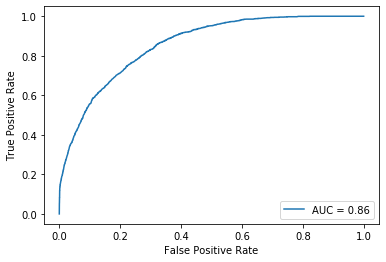

In [43]:
plot_roc_auc(pred_dt)

In [44]:
### Let's make our predictions and save them!

def save_submission_file(trained_model,cols,filename):
    predictions= trained_model.predict(holdout_copy[cols])
    df= {
        "Exited": holdout["Exited"],
        "Prediction": predictions
    }
    submission_df= pd.DataFrame(df)
    submission_df.to_csv(filename,index= False)

In [45]:
save_submission_file(model,optimized_columns,"Churn_predict.csv")

Thank you for reading!